In [1]:
import urllib.request

url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
urllib.request.urlretrieve(url, "iris.csv")

('iris.csv', <http.client.HTTPMessage at 0x7f38e467a6b0>)

In [2]:


# Import required libraries
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Load sample data (Iris dataset)
import urllib.request
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()


#url = "https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv"
#urllib.request.urlretrieve(url, "iris.csv")

#data = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("iris.csv")
#data.show(4)
data = spark.read.csv("preprocessed_PCA.csv", header=True, inferSchema=True)



# Use a OneHotEncoder to encode the "indexedLabel" column
indexer = StringIndexer(inputCol="Class", outputCol="ClassHE")


encoder = OneHotEncoder(inputCol="ClassHE", outputCol="label")


#data_1 = indexer.fit(data).transform(data)

#data_1.show(3)


# Create a vector assembler to combine features into a single column
#assembler = VectorAssembler(inputCols=["sepal_length", "sepal_width", "petal_length", "petal_width"], outputCol="features")
assembler = VectorAssembler(inputCols=["PC1", "PC2","PC3","PC4", "PC5","PC6","PC7", "PC8","PC9","PC11", "PC11","PC12","PC13","PC14", "PC15","PC16","PC17", "PC18","PC19","PC20","PC21","Amount"], outputCol="features")
#data_2 = assembler.transform(data_1).select("label", "features")
#data_2.show(1)

# Transform the data using the vector assembler
#data_2 = assembler.transform(data_1)
#data_2.show(4)
#scaler = StandardScaler(inputCol="features", outputCol="scaled_features")


pipeline = Pipeline(stages=[indexer, encoder, assembler])




Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/09 02:08:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)
#train_data.show(1)

train_data = pipeline.fit(train_data).transform(train_data)
#train_data.show(1)
train_data.show(4)
test_data= pipeline.fit(test_data).transform(test_data)
test_data.select("label","features").show(4)

23/03/09 02:09:07 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+----+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+------------+-----------+------------+------------+------------+------------+------------+------------+-----------+------+-----+-------+-------------+--------------------+
|Time|         PC1|         PC2|         PC3|         PC4|         PC5|         PC6|         PC7|         PC8|         PC9|        PC10|        PC11|       PC12|        PC13|       PC14|        PC15|        PC16|        PC17|        PC18|        PC19|        PC20|       PC21|Amount|Class|ClassHE|        label|            features|
+----+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----

In [20]:
#data_3=data_2.drop("species").select("label", "features")



# Scale the input features to have zero mean and unit variance using a StandardScaler
#scaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")

#scaler_model = scaler.fit(data_2)
#data_4 = scaler_model.transform(data_2)
#data_4.show(3)
#data_5=data_4.select("Class", "scaled_features")
#data_5 = data_5.withColumnRenamed("scaled_features", "features").select("Class","features")
#data_5.show(5)


















In [21]:




# Create a Multilayer Perceptron Classifier model with 3 layers (input, 1 hidden, output)
layers = [4, 5, 3]
mlp = MultilayerPerceptronClassifier(layers=layers,maxIter=100, seed=123, solver="l-bfgs")

# Train the model on the training data
model = mlp.fit(train_data)


IllegalArgumentException: requirement failed: Column label must be of type numeric but was actually of type struct<type:tinyint,size:int,indices:array<int>,values:array<double>>.

In [7]:

# Make predictions on the test data
predictions_LSTM = model.transform(test_data)

# Evaluate the performance of the model using the MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))




Accuracy: 96.55%


In [8]:
# Create a confusion matrix
from pyspark.sql.functions import col

confusion_matrix_LSTM = predictions.groupBy("label", "prediction") \
    .count() \
    .orderBy(["label", "prediction"]) \
    .select("label", "prediction", col("count").alias("frequency"))

# Display the confusion matrix
predictions.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[5.31358529390013...|[297.425784132585...|[1.0,8.5608902468...|       0.0|
|  0.0|[5.55511189816831...|[297.691275577822...|[1.0,6.5240981529...|       0.0|
|  0.0|[5.79663850243650...|[296.192830505096...|[1.0,3.0234914582...|       0.0|
|  0.0|[5.79663850243650...|[295.372518299429...|[1.0,7.0000136300...|       0.0|
|  0.0|[5.9174018045706,...|[298.052019247222...|[1.0,4.5101077309...|       0.0|
|  0.0|[6.03816510670469...|[298.440836811215...|[1.0,3.0295339344...|       0.0|
|  0.0|[6.15892840883878...|[298.676015394992...|[1.0,2.3814968841...|       0.0|
|  0.0|[6.15892840883878...|[299.897405516309...|[1.0,6.8233812035...|       0.0|
|  0.0|[6.15892840883878...|[299.162839193256...|[1.0,1.4470374404...|       0.0|
|  0.0|[6.158928

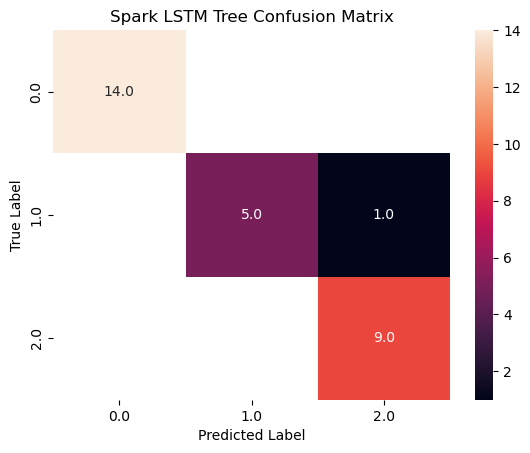

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# Convert the confusion matrix to a Pandas DataFrame
pandas_df = confusion_matrix_LSTM.toPandas()

# Create a pivot table to reshape the data for plotting
pivot = pandas_df.pivot(index="label", columns="prediction", values="frequency")

# Create a heatmap plot of the confusion matrix
#sns.heatmap(pivot, annot=True, fmt="d")
sns.heatmap(pivot, annot=True, fmt=".1f")

# Set the plot title and axis labels
plt.title("Spark LSTM Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

In [10]:
# Compute the precision for class 0
tp = predictions_LSTM.filter("label = 0 and prediction = 0").count()
fp = predictions_LSTM.filter("label = 1 and prediction = 0").count()
precision_0 = tp / (tp + fp)
print("Precision for class 0 = %g" % precision_0)

# Compute the precision for class 1
tp = predictions_LSTM.filter("label = 1 and prediction = 1").count()
fp = predictions_LSTM.filter("label = 0 and prediction = 1").count()
precision_1 = tp / (tp + fp)
print("Precision for class 1 = %g" % precision_1)

Precision for class 0 = 1
Precision for class 1 = 1


In [5]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Read the data
data = spark.read.csv("preprocessed_PCA.csv", header=True, inferSchema=True)

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.7, 0.3])

# Define the transformers
indexer = StringIndexer(inputCol="Class", outputCol="label")
assembler = VectorAssembler(inputCols=["PC1", "PC2","PC3","PC4", "PC5","PC6","PC7", "PC8","PC9","PC10", "PC11","PC12","PC13","PC14", "PC15","PC16","PC17", "PC18","PC19","PC20","PC21","Amount"], outputCol="features")
mlp = MultilayerPerceptronClassifier(layers=[23, 5, 4, 3], seed=1, featuresCol="features", labelCol="label")
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Define the pipeline
pipeline = Pipeline(stages=[indexer, assembler, mlp])

# Train the model
model = pipeline.fit(train_data)

# Make predictions and evaluate the model
predictions = model.transform(test_data)
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % accuracy)

23/03/09 03:08:44 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: OneHotEncoderModel expected 3 categorical values for input column label, but the input column had metadata specifying 2 values.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.feature.OneHotEncoderModel.$anonfun$verifyNumOfValues$1(OneHotEncoder.scala:345)
	at org.apache.spark.ml.feature.OneHotEncoderModel.$anonfun$verifyNumOfValues$1$adapted(OneHotEncoder.scala:335)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.ml.feature.OneHotEncoderModel.verifyNumOfValues(OneHotEncoder.scala:335)
	at org.apache.spark.ml.feature.OneHotEncoderModel.transformSchema(OneHotEncoder.scala:324)
	at org.apache.spark.ml.PipelineStage.transformSchema(Pipeline.scala:71)
	at org.apache.spark.ml

IllegalArgumentException: requirement failed: OneHotEncoderModel expected 3 categorical values for input column label, but the input column had metadata specifying 2 values.